In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tqdm.auto import tqdm

from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

2022-10-12 18:53:55.290598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-12 18:53:55.290671: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/azzam/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class feature_engineering:
    
    def __init__(self):
        self.user_features = []
        self.movie_features = []
    
    def extract_year(self, pattern, title):
        matches = pattern.finditer(title)
        for match in matches:
            return match.group(0)
        
    def movies_eng(self, movies_df):
        pattern = re.compile(r'\d+')
        movies_df['year'] = movies_df['title'].apply(lambda x: self.extract_year(pattern, x))
        movies_df = movies_df.dropna(subset=['year'], axis=0).reset_index(drop=True)
        movies_df['year'] = movies_df['year'].astype('int')
        return movies_df
    
    def one_hot_encoding(self, genre, genres):
        if genre in genres: 
            return 1
        return 0
    
    def ratings_eng(self, movies_df, ratings_df):
        ratings_df = ratings_df.drop('timestamp', axis=1)
        ratings_df = ratings_df.merge(
                     ratings_df.groupby('userId')['rating'].count().rename('num_user_ratings'), 
                     left_on='userId', right_index=True, how='left')
        self.user_features.append('num_user_ratings')
        ratings_df = ratings_df.merge(
                     ratings_df.groupby('movieId')['rating'].count().rename('num_movie_ratings'), 
                     left_on='movieId', right_index=True, how='left')
        self.movie_features.append('num_movie_ratings')
        
        
        # genres one_hot_encoding
        movies_df['genres'] = movies_df['genres'].replace('(no genres listed)', 'Unknown')
        unclean_genres = movies_df['genres'].apply(lambda x: x.split('|'))
        all_genres = []
        for i in range(len(unclean_genres)):
            all_genres.extend(unclean_genres[i])
            all_genres = list(set(all_genres))
        all_genres.sort()
        for genre in tqdm(all_genres):
            self.movie_features.append(genre)
            movies_df[genre] = -1
            movies_df[genre] = movies_df.apply(lambda x: self.one_hot_encoding(genre, x['genres']), axis=1)
        movies_df = movies_df.drop(['title', 'genres'], axis=1)
        
        # others_mean_rating
        for i, user in tqdm(enumerate(ratings_df['userId'].unique()), total=len(ratings_df['userId'].unique())):
            current_user_df = ratings_df[ratings_df['userId'] == user].copy()
            temp_df = ratings_df[ratings_df['userId'] != user].copy()
            others_mean_rating = temp_df.groupby('movieId')['rating'].mean().rename('others_mean_rating')
            temp_df = current_user_df.merge(others_mean_rating, left_on='movieId', right_index=True, how='left')
            if i == 0:
                new_ratings_df = temp_df.copy()
            else:
                new_ratings_df = pd.concat([new_ratings_df, temp_df], axis=0)
        new_ratings_df = new_ratings_df.reset_index(drop=True)
        new_ratings_df['others_mean_rating'] = new_ratings_df['others_mean_rating'].fillna(0)
        ratings_df = new_ratings_df.copy()
        self.movie_features.append('others_mean_rating')
        del new_ratings_df
        
        # user_mean_genre_rating
        merged_df = ratings_df.merge(movies_df, left_on='movieId', right_on='movieId', how='left')
        for genre in tqdm(all_genres):
            temp_df = merged_df[merged_df[genre] == 1]
            temp_df = temp_df.groupby('userId')['rating'].mean().rename(f'user_mean_{genre}_rating')
            merged_df = merged_df.merge(temp_df, left_on='userId', right_index=True, how='left')
            merged_df[f'user_mean_{genre}_rating'].fillna(0, inplace=True)
            self.user_features.append(f'user_mean_{genre}_rating')
        merged_df.fillna(0, inplace=True)
        
        # label scaling
        label = merged_df.pop('rating')
        min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
        label_trans = min_max_scaler.fit_transform(label.to_frame())
        
        # feature scaling
        merged_df = merged_df[self.user_features + self.movie_features]
        all_features = self.user_features + self.movie_features
        qt = QuantileTransformer(random_state=123)
        merged_df_trans = pd.DataFrame(qt.fit_transform(merged_df), columns=all_features)
        
        return merged_df_trans, label_trans, label, qt, min_max_scaler
    
    def __call__(self):
        movies_df =pd.read_csv('movies.csv')
        ratings_df = pd.read_csv('ratings.csv')
        tags_df = pd.read_csv('tags.csv')
        
        movies_df = self.movies_eng(movies_df)
        merged_df_trans, label_trans, label, qt, min_max_scaler = self.ratings_eng(movies_df, ratings_df)
        return merged_df_trans, label_trans, label, qt, min_max_scaler, self.user_features, self.movie_features
    
feat_eng = feature_engineering()
merged_df_trans, label_trans, label, qt, min_max_scaler, user_features, movie_features = feat_eng()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/610 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
class recommenderModelTrain:
    
    def __init__(self, merged_df_trans, label_trans, label, user_features, movie_features):
        
        self.merged_df_trans = merged_df_trans
        self.label_trans = label_trans
        self.label = label
        self.user_features = user_features
        self.movie_features = movie_features
        
        self.user_nn = tf.keras.Sequential([
                            layers.Dense(256, activation='relu'),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(64, activation='relu'),
                            layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)),
                        ])

        self.movie_nn = tf.keras.Sequential([
                            layers.Dense(256, activation='relu'),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(64, activation='relu'),
                            layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)),
                        ])
        
    def datasets(self):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
        for train_idx, valid_idx in skf.split(self.merged_df_trans, self.label.astype('str')):
            break
            
        X_train, y_train = self.merged_df_trans.iloc[train_idx, :], self.label_trans[train_idx]
        X_valid, y_valid = self.merged_df_trans.iloc[valid_idx, :], self.label_trans[valid_idx]
        
        X_train_ds = tf.data.Dataset.from_tensor_slices((X_train[user_features], X_train[movie_features]))
        y_train_ds = tf.data.Dataset.from_tensor_slices(y_train)
        train_ds = tf.data.Dataset.zip((X_train_ds, y_train_ds)).shuffle(256).batch(128).prefetch(-1).cache()

        X_valid_ds = tf.data.Dataset.from_tensor_slices((X_valid[user_features], X_valid[movie_features]))
        y_valid_ds = tf.data.Dataset.from_tensor_slices(y_valid)
        valid_ds = tf.data.Dataset.zip((X_valid_ds, y_valid_ds)).batch(128).prefetch(-1).cache()
        
        return train_ds, valid_ds, y_valid
    
    def recommender_model(self):
        user_inputs = layers.Input(shape=(len(self.user_features),), name='user_inputs')
        movie_inputs = layers.Input(shape=(len(self.movie_features),), name='movie_inputs')

        user_embed = self.user_nn(user_inputs)
        movie_embed = self.movie_nn(movie_inputs)

        outputs = layers.Dot(axes=-1, normalize=False)([user_embed, movie_embed])

        model = tf.keras.Model(inputs=[user_inputs, movie_inputs], outputs=outputs)
        model.compile(loss='mse',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                      metrics='mean_absolute_error',
                     )
        return model 

    def __call__(self):
        train_ds, valid_ds, y_valid = self.datasets()
        
        tf.keras.backend.clear_session()
        model = self.recommender_model()
        ckpt = tf.keras.callbacks.ModelCheckpoint(
                                        filepath='best_weights.h5',
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True,
                                        save_weights_only=True,
                                        verbose=1,
                                    )
        model.fit(train_ds,
                  validation_data=valid_ds,
                  epochs=30,
                  callbacks=[ckpt],
                 )
        return model, valid_ds, y_valid
    
trainer = recommenderModelTrain(merged_df_trans, label_trans, label, user_features, movie_features)
model, valid_ds, y_valid = trainer()

2022-10-12 18:55:31.416534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-12 18:55:31.416576: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-12 18:55:31.416602: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Azzam): /proc/driver/nvidia/version does not exist
2022-10-12 18:55:31.416963: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30


2022-10-12 18:55:35.813370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-12 18:55:35.869692: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz


631/631 [==============================] - 6s 4ms/step - loss: 0.1714 - mean_absolute_error: 0.3210 - val_loss: 0.1725 - val_mean_absolute_error: 0.3163

Epoch 00001: val_loss improved from inf to 0.17254, saving model to best_weights.h5
Epoch 2/30
631/631 [==============================] - 2s 3ms/step - loss: 0.1599 - mean_absolute_error: 0.3080 - val_loss: 0.1633 - val_mean_absolute_error: 0.3077

Epoch 00002: val_loss improved from 0.17254 to 0.16328, saving model to best_weights.h5
Epoch 3/30
631/631 [==============================] - 2s 3ms/step - loss: 0.1583 - mean_absolute_error: 0.3061 - val_loss: 0.1573 - val_mean_absolute_error: 0.3030

Epoch 00003: val_loss improved from 0.16328 to 0.15731, saving model to best_weights.h5
Epoch 4/30
631/631 [==============================] - 2s 3ms/step - loss: 0.1558 - mean_absolute_error: 0.3034 - val_loss: 0.1553 - val_mean_absolute_error: 0.3014

Epoch 00004: val_loss improved from 0.15731 to 0.15531, saving model to best_weights.h5
Epo

# Evaluation

In [4]:
model.load_weights('best_weights.h5')
preds = min_max_scaler.inverse_transform(model.predict(valid_ds, verbose=1))
y_valid = min_max_scaler.inverse_transform(y_valid)

158/158 [==============================] - 1s 2ms/step


In [5]:
mae = mean_absolute_error(y_valid, preds.flatten())
mse = mean_squared_error(y_valid, preds.flatten())

print(f'Mean Squared Error: {mse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')

Mean Squared Error: 0.751
Mean Absolute Error: 0.667


/home/azzam/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/azzam/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/azzam/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

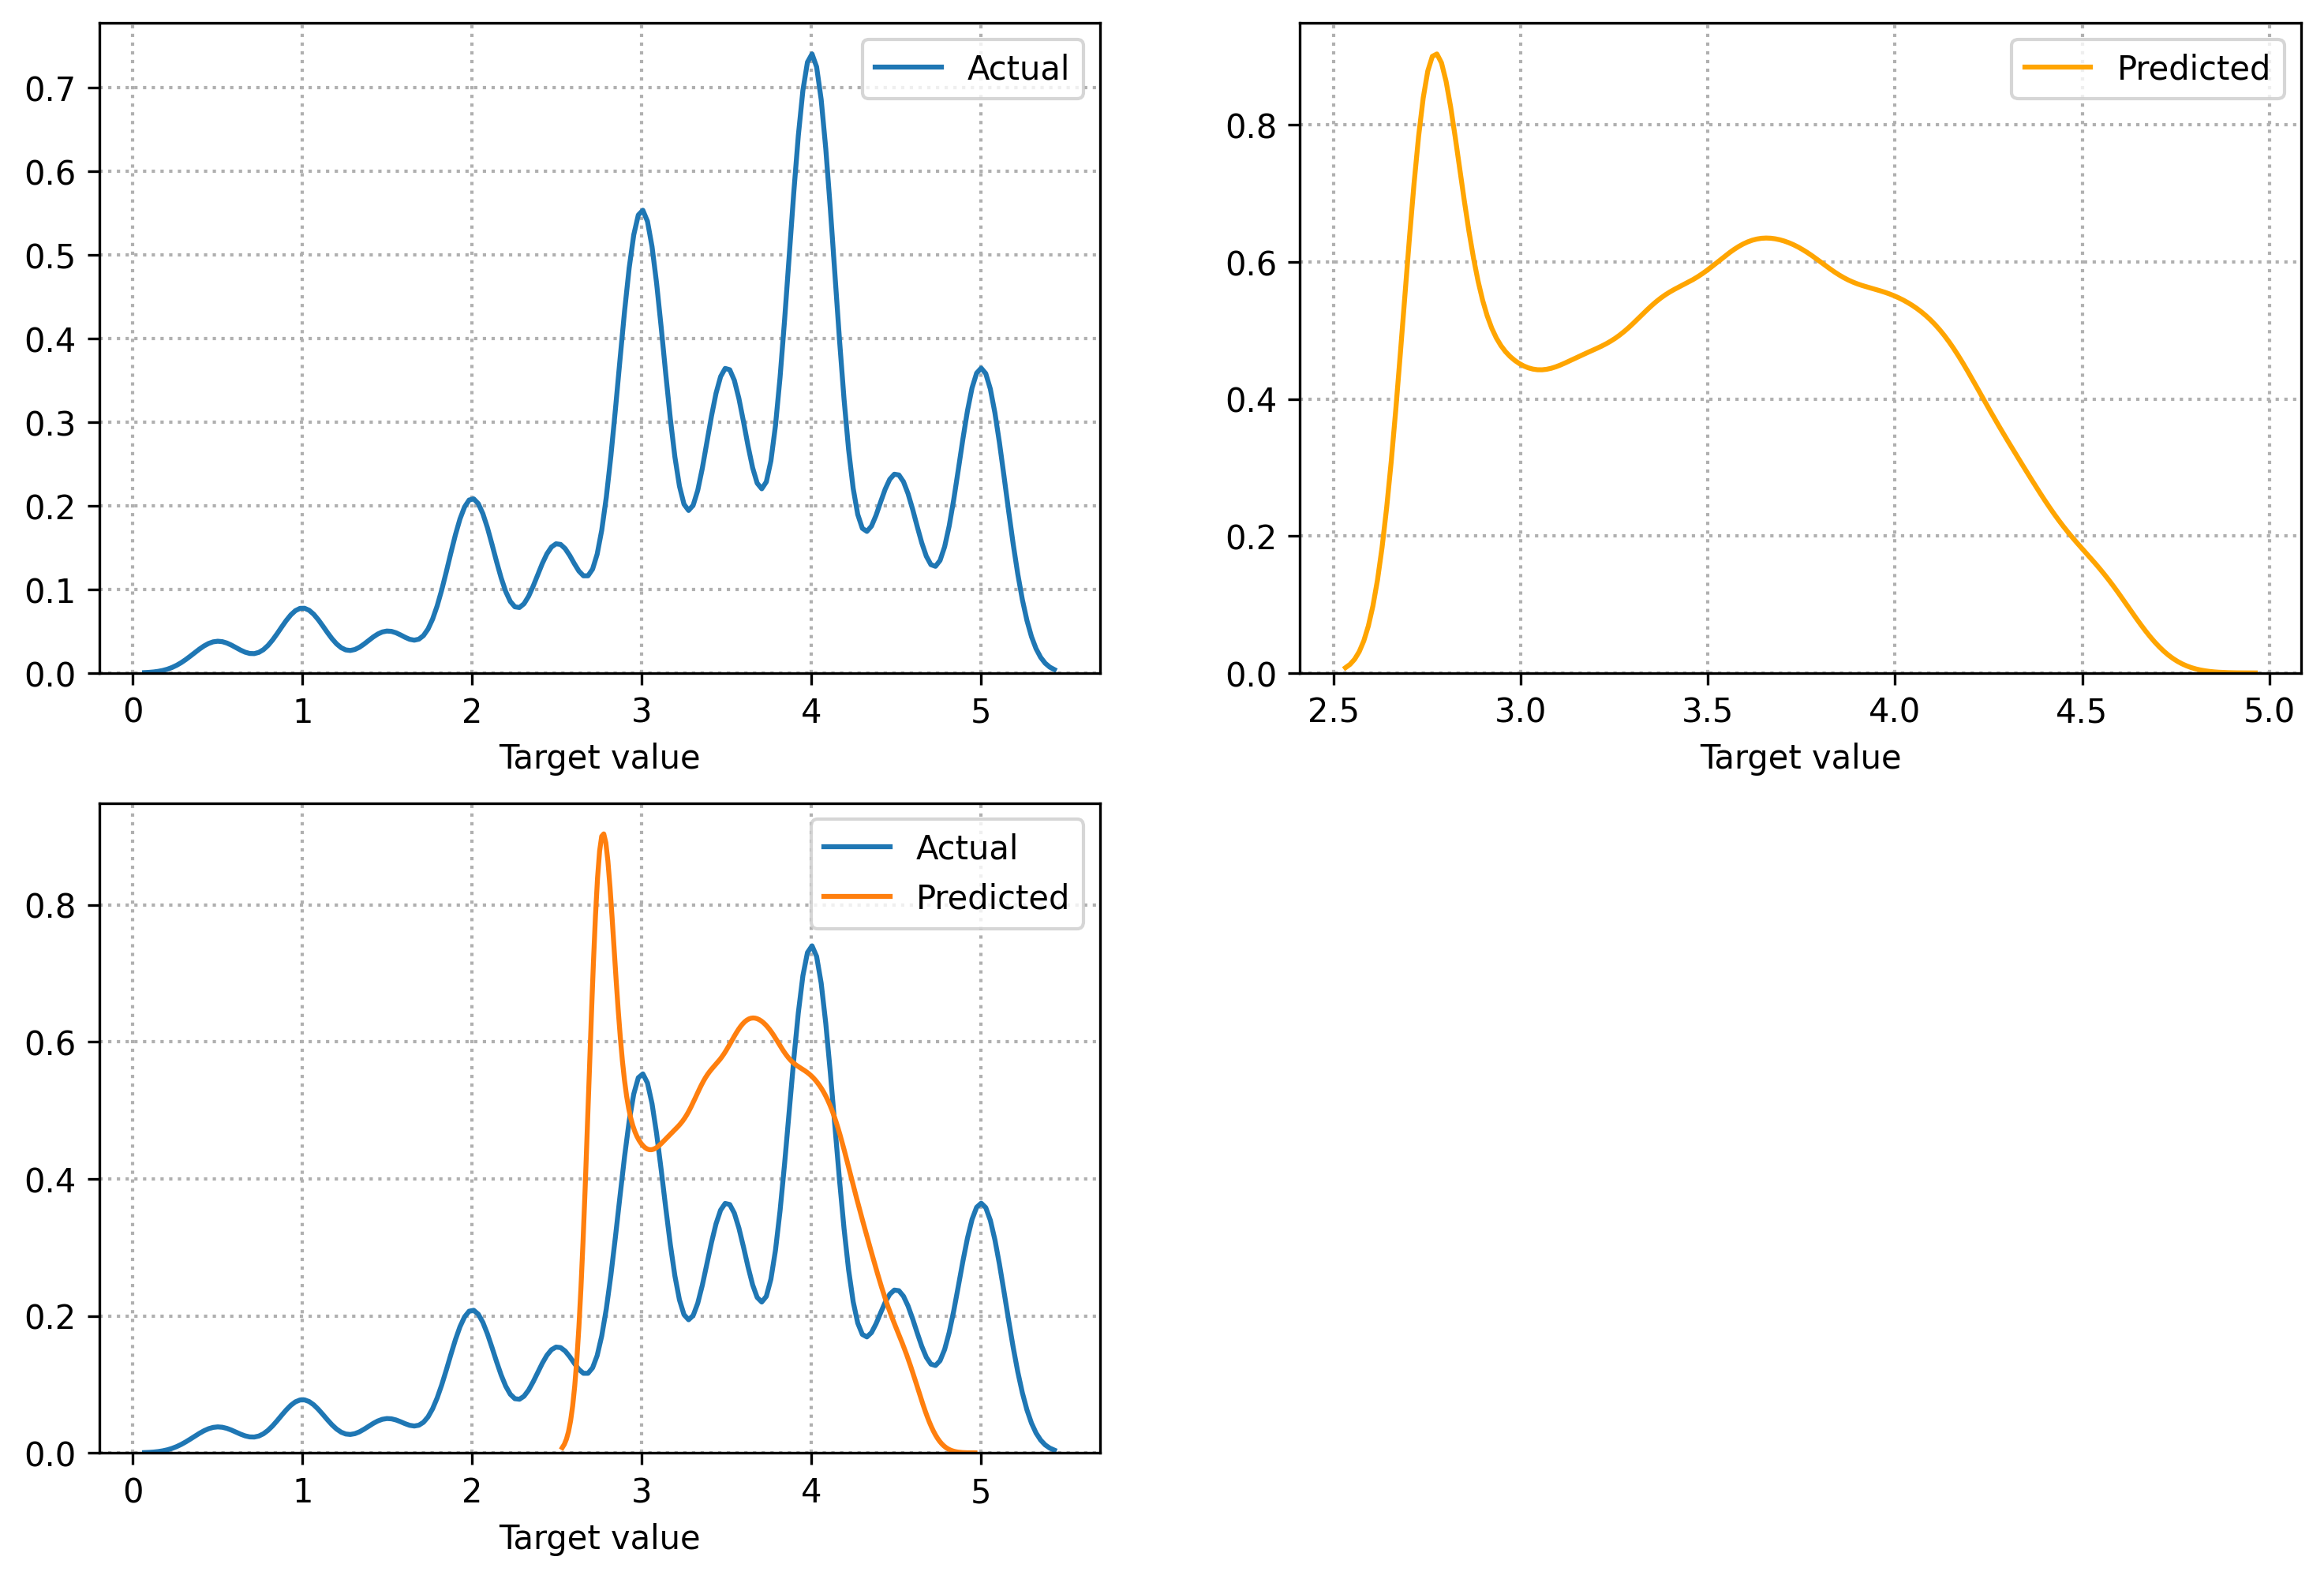

In [6]:
plt.figure(figsize=(12, 8), dpi=300)

plt.subplot(2, 2, 1)
sns.distplot(y_valid, hist=False)
plt.legend(['Actual'])
plt.xlabel('Target value')
plt.ylabel('')
plt.grid(linestyle=':', linewidth=1)

plt.subplot(2, 2, 2)
sns.distplot(preds.flatten(), hist=False, color='orange')
plt.legend(['Predicted'])
plt.xlabel('Target value')
plt.ylabel('')
plt.grid(linestyle=':', linewidth=1)

plt.subplot(2, 2, 3)
sns.distplot(y_valid, hist=False)

plt.subplot(2, 2, 3)
sns.distplot(preds.flatten(), hist=False)

plt.legend(['Actual', 'Predicted'])
plt.xlabel('Target value')
plt.ylabel('')
plt.grid(linestyle=':', linewidth=1)

plt.show()